In [44]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats
import phik
import graphviz
import lightgbm
import warnings
import sklearn
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree as xgbtree
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from scipy.stats import uniform
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")
sb.set_theme()

## This notebook mainly contains the results of our Classification Tree and Random Forest models

## Data Visualization and Understanding

In [45]:
churndata = pd.read_csv('churn_model.csv')  #extracting data
churndata.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data Preparation

In [46]:
#converting Area code(numerical type) to categorical
churndata['Area code'] = churndata['Area code'].astype('object')    
print(churndata.dtypes)

State                      object
Account length              int64
Area code                  object
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object


### Splitting data set into Categorical and Numerical types

In [47]:
churn_cat_data = churndata.select_dtypes(include=[object,bool])

In [48]:
churn_cat_data.describe()

,State,Area code,International plan,Voice mail plan,Churn
count,2666,2666,2666,2666,2666
unique,51,3,2,2,2
top,WV,415,No,No,False
freq,88,1318,2396,1933,2278


### Numerical Data Correlation

In [49]:
churn_num_data = churndata.select_dtypes(exclude=[object])

In [50]:
churn_num_data.head()

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data Processing

### One Hot Encoding (OHE)

####  OHE is used to encode categorical data into integers. <br>It ensure compatibility with machine learning models that may require numerical inputs. <br>OHE also treats each category as independent and preserves the non-ordinal relationship between categories. <br>

In [51]:
#One hot encoding to convert categorical variables into numerical

churn_cat = churndata.select_dtypes(include=[object]).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(churndata[churn_cat])
encoded_cat_df = pd.DataFrame(encoded_data,columns = encoder.get_feature_names_out(churn_cat))
churn_OHE = churndata
churn_OHE = churn_OHE.drop(churn_cat,axis = 1)                  #removal of old categorical data from dataset
churn_OHE = pd.concat([churn_OHE, encoded_cat_df],axis = 1)     #appending new one hot encoded variables into dataseet
churn_OHE

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,...,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,79,0,134.7,98,22.90,189.7,68,16.12,221.4,128,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2662,192,36,156.2,77,26.55,215.5,126,18.32,279.1,83,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2663,68,0,231.1,57,39.29,153.4,55,13.04,191.3,123,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2664,28,0,180.8,109,30.74,288.8,58,24.55,191.9,91,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# Models

## Train-Test-split and SMOTE

In [52]:
#since our data is heavily skewed towards False(churn), we used SMOTE to balance our dataset

Predictors = churn_OHE.drop(['Churn'],axis = 1)
Response = churn_OHE['Churn']

Predictors_train , Predictors_test, Response_train, Response_test = train_test_split(Predictors, Response, test_size = 0.2, random_state= 10)
smt = SMOTE(random_state= 10)
Predictors_train , Response_train = smt.fit_resample(Predictors_train,Response_train)

## Classification Tree Model

#### Classification Tree is a predictive model that draw conclusions about a set of observations. <br>Classification tree mimics human reasoning and logic to arrive at a decision. <br> Furthermore, since our data set have both categorical and numerical data, classification tree's ability to handle both types data allows it to easily navigating the dataset and helps in solving our issue of predicting churn.

In [53]:
#Classification Tree
Ctree = DecisionTreeClassifier(random_state=0)
Ctree.fit(Predictors_train, Response_train)
Response_pred = Ctree.predict(Predictors_test)

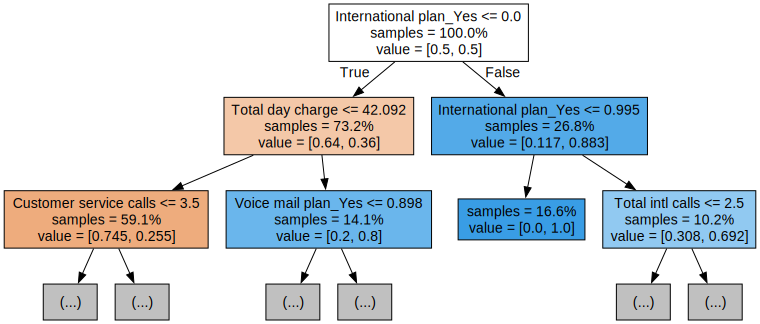

In [54]:
dot_data = export_graphviz(Ctree, 
                            feature_names = Predictors_train.columns,
                            filled = True,
                            max_depth = 2,
                            impurity = False,
                            proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

Text(0.5, 427.9555555555555, 'Predicted Churn')

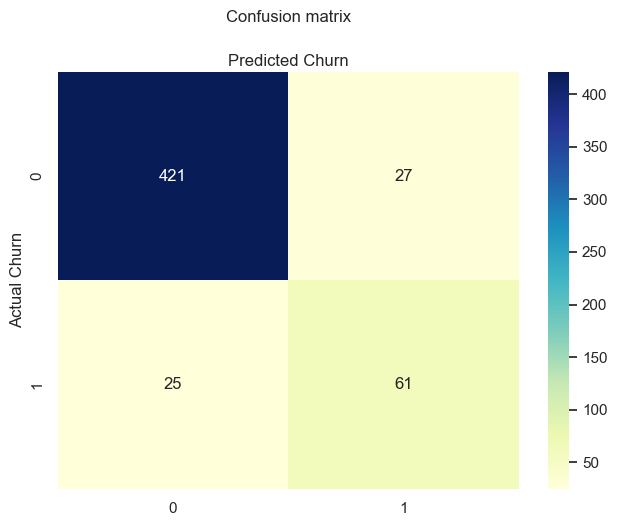

In [55]:
#creating visualization of predicted and actual results
cnf_matrix = confusion_matrix(Response_test, Response_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

In [56]:
#Classification Tree results
print(classification_report(y_true=Response_test,y_pred=Response_pred,digits = 3))
accuracy = accuracy_score(Response_test,Response_pred)

print("Accuracy : ", accuracy)

probs = Ctree.predict_proba(Predictors_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response_test, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC: ", roc_auc)


              precision    recall  f1-score   support

       False      0.944     0.940     0.942       448
        True      0.693     0.709     0.701        86

    accuracy                          0.903       534
   macro avg      0.819     0.825     0.821       534
weighted avg      0.904     0.903     0.903       534

Accuracy :  0.9026217228464419
ROC AUC:  0.8245172342192691


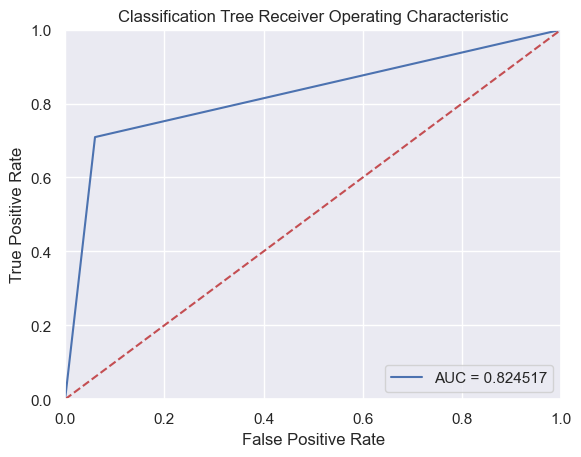

In [57]:
plt.title('Classification Tree Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

`Accuracy` : represents the ratio of correctly predicted observations to the total observations. <br>
Accuracy = Total Number of Predictions / Number of Correct Predictions
​

`Precision` : measures the proportion of true positive predictions (correctly predicted positive cases) out of all positive predictions made by the model. <br> Precision = ( True Positive (TP) + False Positives (FP) ) / True Positives
​

`Recall` or sensitivity: measures the proportion of true positive predictions (correctly predicted positive cases) out of all actual positive cases in the dataset. <br> Recall= True Positives(TP) / ( False Negatives(FN) +  True Positives(TP) )
​

`F1 score` : combines both precision and recall into a single metric, providing a balanced assessment of a model's performance.
<br> F1 = 2×Precision×Recall / Precision+Recall 

The F1 score is particularly useful to balance both precision and recall, and there is an uneven class distribution in the dataset. 
​

`​ROC` (Receiver Operating Characteristic) `AUC` (Area Under the Curve) measures the area under the ROC curve, which is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.


The ROC AUC score ranges from 0 to 1, where:

A score of 1 indicates perfect performance, where the model correctly identifies all positive cases a makes no false positive predictions. <br>
A score of 0.5 indicates performance equivalent to random guessing

Generally, higher ROC AUC scores indicate better discrimination between positive and negative classes by the model.



## Random Forest Model

#### Random forest is a complilation of classification trees, as such, it has the benefits of classification trees, furthermore since random forest combines multiple tress to produce an output, small deviations in data is not as impactful in random forest as compared to classification tree. 

In [58]:
#random Forest model
rf = RandomForestClassifier()
rf.fit(Predictors_train, Response_train)

RandomForestClassifier()

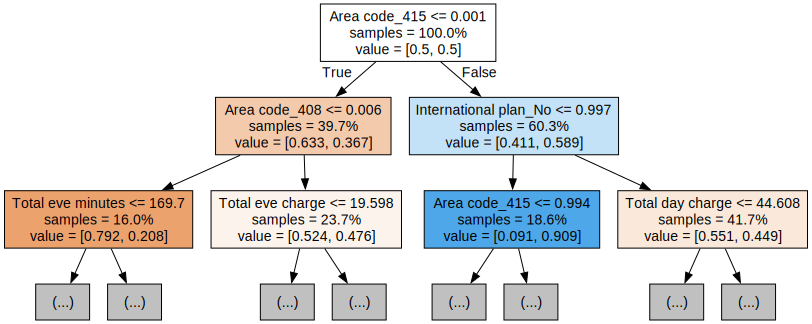

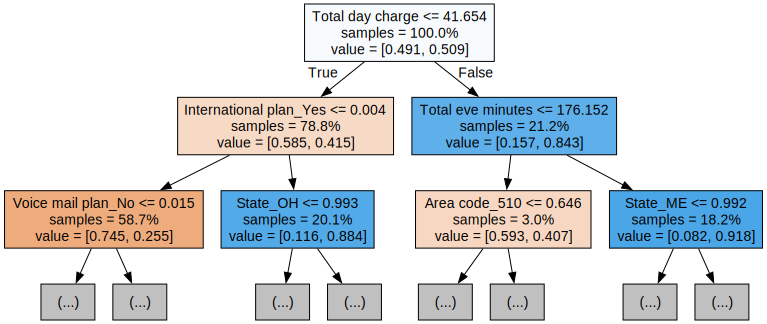

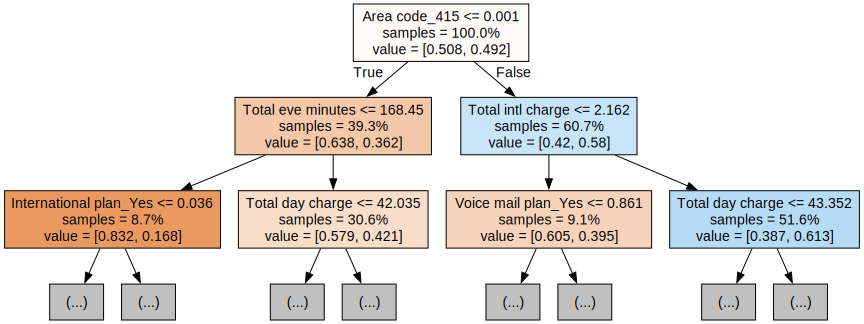

In [59]:
#sample of decision tress within random forest
for i in range(3):
    rftree = rf.estimators_[i]
    dot_data = export_graphviz(rftree, 
                               feature_names = Predictors_train.columns,
                               filled = True,
                               max_depth = 2,
                               impurity = False,
                               proportion = True)
    graph = graphviz.Source(dot_data)
    display(graph)

Text(0.5, 427.9555555555555, 'Predicted Churn')

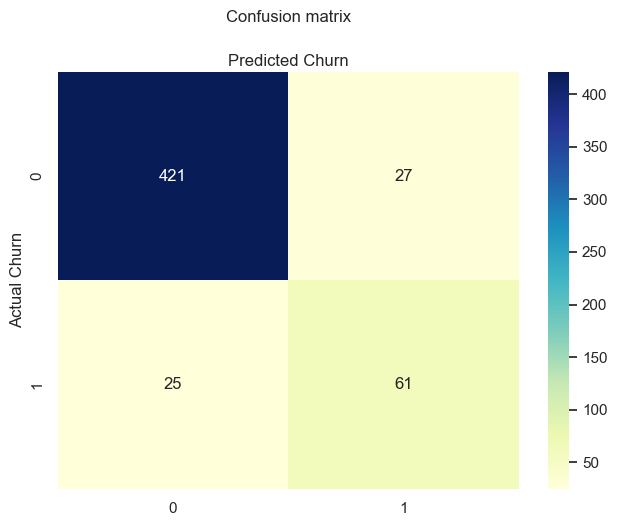

In [60]:
#creating visualization of predicted and actual results
cnf_matrix = confusion_matrix(Response_test, Response_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

In [61]:
#Random Forest results
Response_predict = rf.predict(Predictors_test)
print(classification_report(y_true=Response_test,y_pred=Response_predict,digits = 3))
accuracy = accuracy_score(Response_test,Response_predict)

print("Accuracy : ", accuracy)

probs = rf.predict_proba(Predictors_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response_test, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC:", roc_auc)

              precision    recall  f1-score   support

       False      0.928     0.973     0.950       448
        True      0.812     0.605     0.693        86

    accuracy                          0.914       534
   macro avg      0.870     0.789     0.822       534
weighted avg      0.909     0.914     0.909       534

Accuracy :  0.9138576779026217
ROC AUC: 0.892532703488372


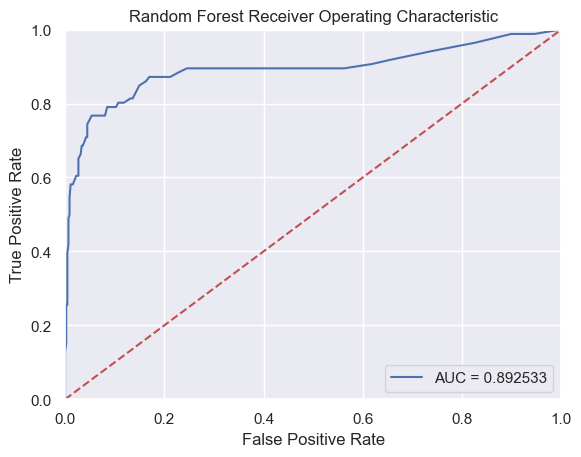

In [62]:
plt.title('Random Forest Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest with Hyper Parameters

#### To improve the Random Forest model, we can tune the hyper parameters to optimize the model. Utilized RandomsearchCV to tune.

In [63]:
#hyper parameters tuning
param_dist = {'n_estimators': randint(1,1000),
              'max_depth': randint(1,100)}

rand_search = RandomizedSearchCV(rf,param_distributions=param_dist,
                                 n_iter=30,cv=10, n_jobs=-1,
                                 scoring='accuracy')

rand_search.fit(Predictors_train,Response_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000137CFEA77A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000137D14786B0>},
                   scoring='accuracy')

In [64]:
#tuning results
best_rf = rand_search.best_estimator_
print("Best hyperparameters:", best_rf)
Response_predict = best_rf.predict(Predictors_test)

Best hyperparameters: RandomForestClassifier(max_depth=80, n_estimators=910)


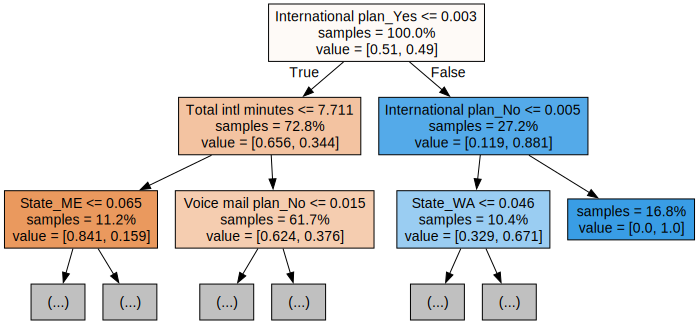

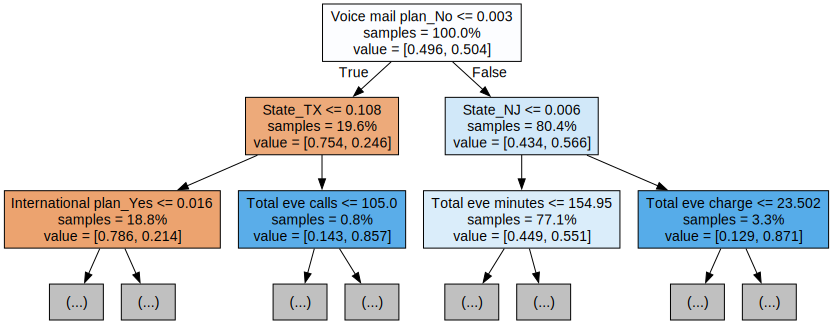

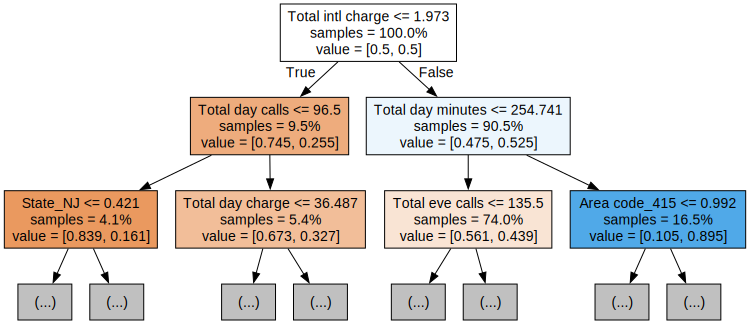

In [65]:
#sample of decision tress within random forest with hyper parameters
for i in range(3):
    rftree = best_rf.estimators_[i]
    dot_data = export_graphviz(rftree, 
                               feature_names = Predictors_train.columns,
                               filled = True,
                               max_depth = 2,
                               impurity = False,
                               proportion = True)
    graph = graphviz.Source(dot_data)
    display(graph)

International plan_Yes    0.096037
Total day charge          0.094965
International plan_No     0.094572
Total day minutes         0.094220
Customer service calls    0.061541
Area code_415             0.045484
Area code_408             0.036524
Area code_510             0.035053
Total eve minutes         0.031829
Total eve charge          0.031464
dtype: float64


<Axes: >

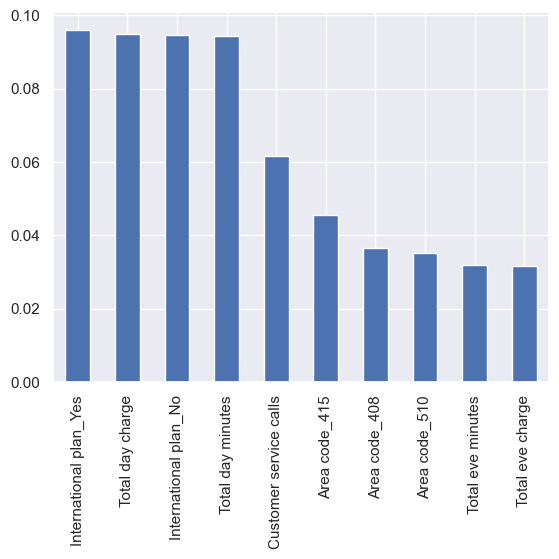

In [66]:
#importance of certain variables to predict churn
feature_importance = pd.Series(best_rf.feature_importances_,
                               index = Predictors_train.columns).sort_values(ascending=False)
feature_importance_trunc = feature_importance.iloc[0:10]
print(feature_importance_trunc)
feature_importance_trunc.plot.bar()

Text(0.5, 427.9555555555555, 'Predicted Churn')

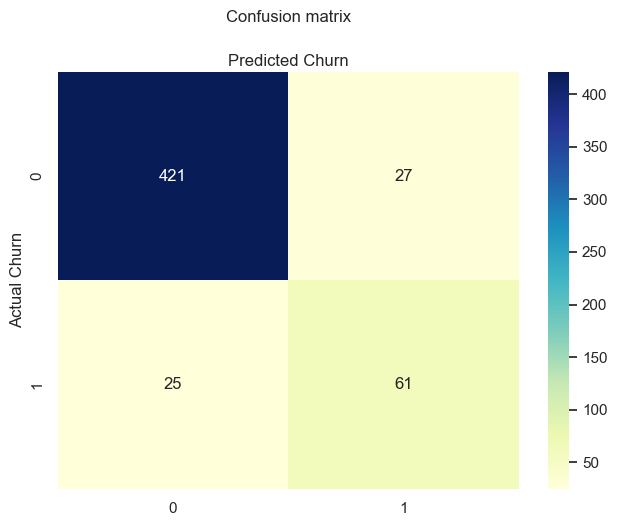

In [67]:
#creating visualization of predicted and actual results
cnf_matrix = confusion_matrix(Response_test, Response_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

In [68]:
#results of Random Forest with Hyper parameters
print(classification_report(Response_test,Response_predict,digits = 3))
accuracy = accuracy_score(Response_test,Response_predict)

print("Accuracy :", accuracy)

probs = best_rf.predict_proba(Predictors_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response_test, preds)
roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC:", roc_auc)

              precision    recall  f1-score   support

       False      0.932     0.980     0.955       448
        True      0.857     0.628     0.725        86

    accuracy                          0.923       534
   macro avg      0.895     0.804     0.840       534
weighted avg      0.920     0.923     0.918       534

Accuracy : 0.9232209737827716
ROC AUC: 0.9047446013289036


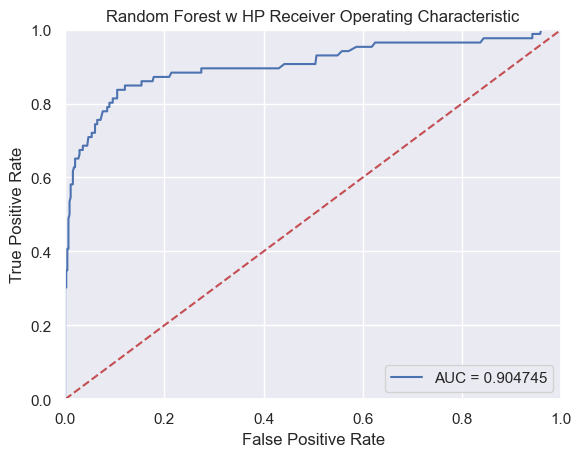

In [69]:
plt.title('Random Forest w HP Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### After tuning, the random forest model is improved

# Cross Checking and Validation of Model

#### We double-checked the accuracy and performance of the models by inputting another test dataset <br> This test dataset can be found on the Kaggle dataset page

In [70]:
#Checking model accuracy against new set of test data
#To determine overfitting / underfitting
churn_test_data = pd.read_csv('churn_test.csv')

In [71]:
#One hot encoding the test data
churn_test_cat = churn_test_data.select_dtypes(include=[object]).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_test_data = encoder.fit_transform(churn_test_data[churn_test_cat])
encoded_test_cat_df = pd.DataFrame(encoded_test_data,columns = encoder.get_feature_names_out(churn_test_cat))
churn_test_OHE = churn_test_data
churn_test_OHE = churn_test_OHE.drop(churn_test_cat,axis = 1)
churn_test_OHE = pd.concat([churn_test_OHE, encoded_test_cat_df],axis = 1)
churn_test_OHE

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,...,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,117,408,0,184.5,97,31.37,351.6,80,29.89,215.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,65,415,0,129.1,137,21.95,228.5,83,19.42,208.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,161,415,0,332.9,67,56.59,317.8,97,27.01,160.6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,111,415,0,110.4,103,18.77,137.3,102,11.67,189.6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,49,510,0,119.3,117,20.28,215.1,109,18.28,178.7,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,114,415,26,137.1,88,23.31,155.7,125,13.23,247.6,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
663,106,408,29,83.6,131,14.21,203.9,131,17.33,229.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
664,60,415,0,193.9,118,32.96,85.0,110,7.23,210.1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
665,159,415,0,169.8,114,28.87,197.7,105,16.80,193.7,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [72]:
#splitting churn and other variables
Response = churn_OHE['Churn']
Predictors = churn_OHE.drop(['Churn'],axis = 1)

              precision    recall  f1-score   support

       False      0.989     0.988     0.989      2278
        True      0.931     0.936     0.933       388

    accuracy                          0.980      2666
   macro avg      0.960     0.962     0.961      2666
weighted avg      0.981     0.980     0.981      2666

Accuracy :  0.9804951237809453
ROC AUC: 0.9618572540571853


<Axes: >

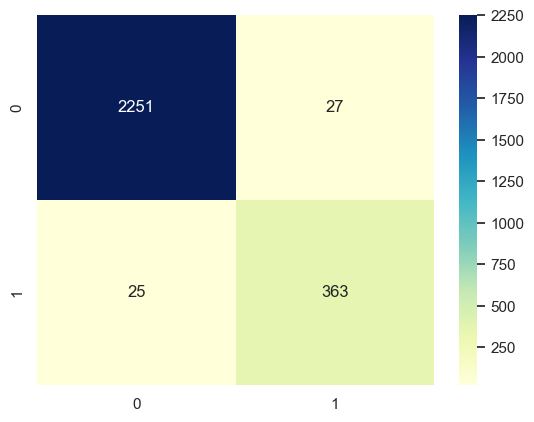

In [73]:
#Validating Classification Tree Model
CT_Response_predict = Ctree.predict(Predictors)
print(classification_report(y_true=Response,y_pred=CT_Response_predict,digits = 3))
classifi = classification_report(y_true=Response,y_pred=CT_Response_predict,digits = 3,output_dict=True)
CT_Precision = classifi['weighted avg']['precision']
CT_recall = classifi['weighted avg']['recall']
CT_f1 = classifi['weighted avg']['f1-score']
CT_accuracy = accuracy_score(Response,CT_Response_predict)

print("Accuracy : ", CT_accuracy)

probs = Ctree.predict_proba(Predictors)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response, preds)
CT_roc_auc = metrics.auc(fpr, tpr)


print("ROC AUC:", CT_roc_auc)
cm = confusion_matrix(Response,CT_Response_predict)
sb.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

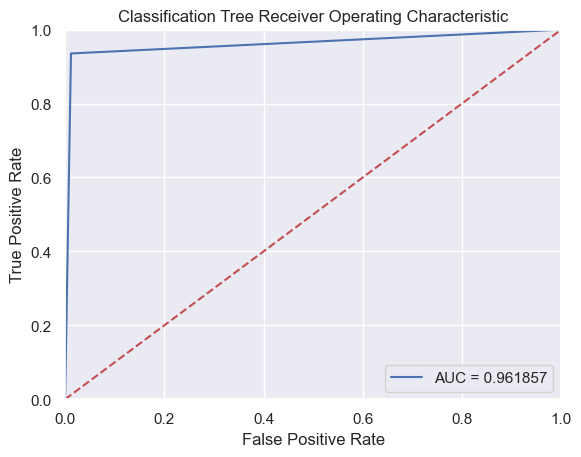

In [74]:
plt.title('Classification Tree Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % CT_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

       False      0.985     0.995     0.990      2278
        True      0.967     0.912     0.939       388

    accuracy                          0.983      2666
   macro avg      0.976     0.954     0.964      2666
weighted avg      0.983     0.983     0.983      2666

Accuracy :  0.9827456864216054
ROC : 0.9875144818659884


<Axes: >

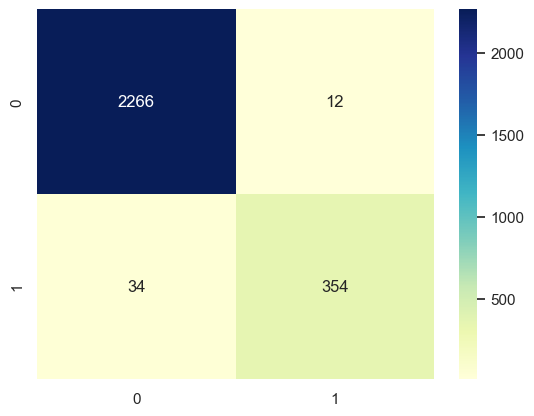

In [75]:
#Validating Random Forest Model
RF_Response_predict = rf.predict(Predictors)
print(classification_report(y_true=Response,y_pred=RF_Response_predict,digits = 3))
classifi = classification_report(y_true=Response,y_pred=RF_Response_predict,digits = 3,output_dict=True)
RF_Precision = classifi['weighted avg']['precision']
RF_recall = classifi['weighted avg']['recall']
RF_f1 = classifi['weighted avg']['f1-score']
RF_accuracy = accuracy_score(Response,RF_Response_predict)

print("Accuracy : ", RF_accuracy)

probs = rf.predict_proba(Predictors)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response, preds)
RF_roc_auc = metrics.auc(fpr, tpr)

print("ROC :", RF_roc_auc)

cm = confusion_matrix(Response,RF_Response_predict)
sb.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

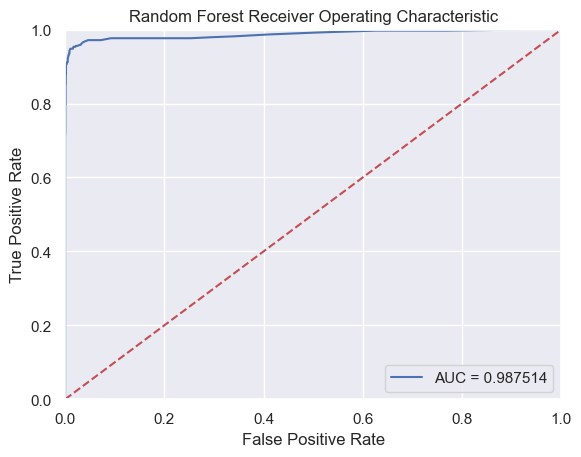

In [76]:
plt.title('Random Forest Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % RF_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

       False      0.986     0.996     0.991      2278
        True      0.975     0.918     0.946       388

    accuracy                          0.985      2666
   macro avg      0.981     0.957     0.968      2666
weighted avg      0.985     0.985     0.984      2666

Accuracy :  0.9846211552888222
ROC AUC: 0.9902796131531549


<Axes: >

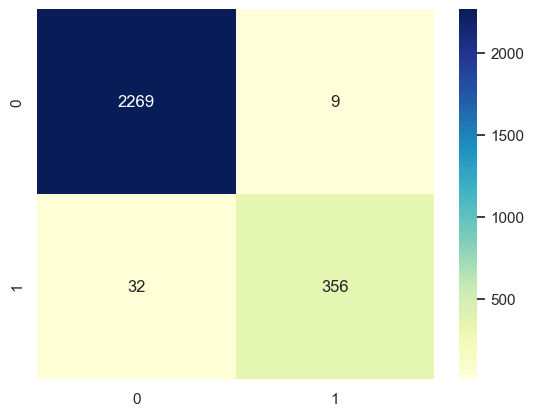

In [77]:
#Validating Random Forest with Hyperparameter Model
RFH_Response_predict = best_rf.predict(Predictors)
print(classification_report(y_true=Response,y_pred=RFH_Response_predict,digits = 3))
classifi = classification_report(y_true=Response,y_pred=RFH_Response_predict,digits = 3,output_dict=True)
RFH_Precision = classifi['weighted avg']['precision']
RFH_recall = classifi['weighted avg']['recall']
RFH_f1 = classifi['weighted avg']['f1-score']
RFH_accuracy = accuracy_score(Response,RFH_Response_predict)

print("Accuracy : ", RFH_accuracy)

probs = best_rf.predict_proba(Predictors)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Response, preds)
RFH_roc_auc = metrics.auc(fpr, tpr)

print("ROC AUC:", RFH_roc_auc)


cm = confusion_matrix(Response,RFH_Response_predict)
sb.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

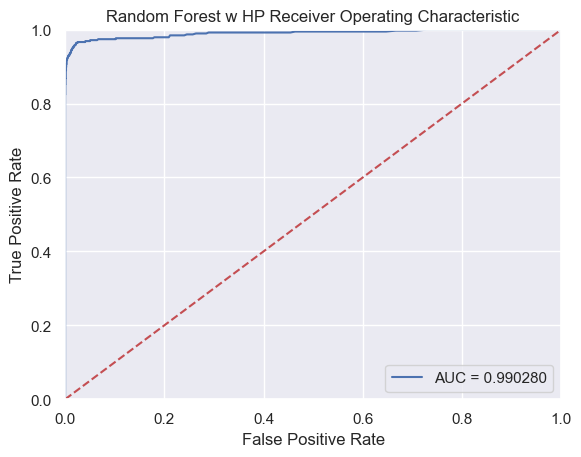

In [78]:
plt.title('Random Forest w HP Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.6f' % RFH_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Plot table and graph of performance measure

In [79]:
dict = {
        'Accuracy':[CT_accuracy, RF_accuracy, RFH_accuracy] ,
        'ROC AUC': [CT_roc_auc,RF_roc_auc,RFH_roc_auc] ,
        'Precision': [CT_Precision,RF_Precision,RFH_Precision] ,
        'Recall': [CT_recall, RF_recall, RFH_recall] ,
        'F1-score': [CT_f1,RF_f1,RFH_f1]
        }


list = ['Classifcation Tree','Random Forest', 'Random Forest w/ hyperparameter',]

In [80]:
performance = pd.DataFrame(dict, index = list)
performance.sort_values(by="Accuracy",ascending=False)

,Accuracy,ROC AUC,Precision,Recall,F1-score
Random Forest w/ hyperparameter,0.984621,0.990280,0.984528,0.984621,0.984425
Random Forest,0.982746,0.987514,0.982597,0.982746,0.982535
Classifcation Tree,0.980495,0.961857,0.980539,0.980495,0.980516


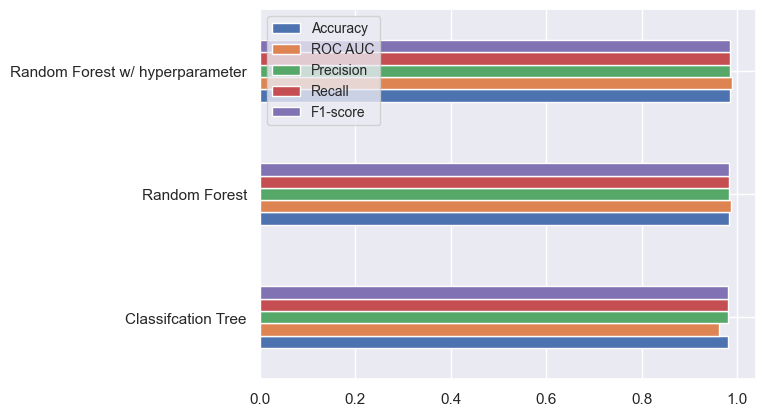

In [81]:
performance.plot.barh()
plt.legend(loc='upper left',fontsize='small')
plt.show()

<h4> 
Model Ranking:
Assessed via Accuracy and ROC


1) Random Forest with Hyper Parameter       (Acc:0.985 / ROC: 0.989)
2) Random Forest                            (Acc:0.984 / ROC: 0.989)
3) Classification Tree                      (Acc:0.980 / ROC: 0.962)


</h4>

## For the other models, please view the other notebook or view the compiled ipynb